In [1]:
import cv2
import numpy as np
from glob import glob
import json
from tqdm import tqdm
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
start_time = '20210805_203120'

metadata_list = glob(f'dataset/{start_time}/metadata*.json')

len(metadata_list)

394

In [3]:
img_size = 299

x_data = np.zeros((len(metadata_list) * 5, img_size, img_size, 3), dtype=np.float32)
y_data = np.zeros((len(metadata_list) * 5, 2), dtype=np.float32)

i = 0

for metadata_path in tqdm(metadata_list):
    with open(metadata_path, 'r') as f:
        metadata_5 = json.load(f)

        for metadata in metadata_5:
            img = cv2.imread(f'dataset/{start_time}/{metadata["img_path"]}')
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype(np.float32)
            img = img / 127.5 - 1.
            
            x_data[i] = img
            y_data[i] = [metadata['lat'], metadata['lng']]

            i += 1

print(x_data.shape, y_data.shape)

100%|██████████| 394/394 [00:29<00:00, 13.45it/s]

(1970, 299, 299, 3) (1970, 2)


In [4]:
len(np.unique(y_data, axis=0))

533

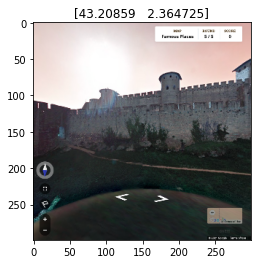

In [5]:
import matplotlib.pyplot as plt

plt.title(str(y_data[-1]))
plt.imshow((x_data[-1] + 1.) / 2.)

In [6]:
import folium

m = folium.Map()

for coords in y_data[:20]:
    folium.Marker([coords[0], coords[1]], popup=f"{str(coords)}").add_to(m)
m

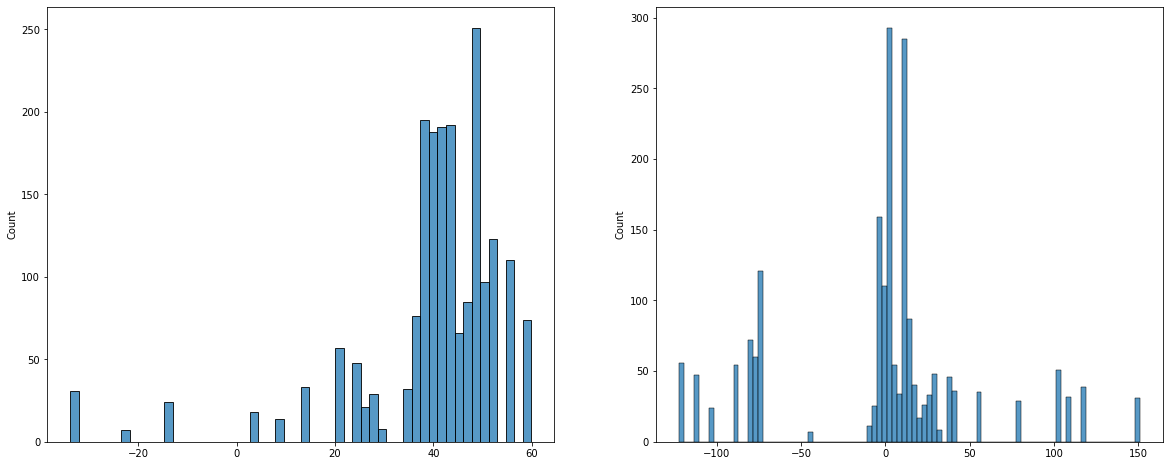

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(x=y_data[:, 0], ax=ax[0])
sns.histplot(x=y_data[:, 1], ax=ax[1])
plt.show()

In [8]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='ai-geoguessr')
geolocator.reverse('52.509669, 13.376294', language='en').raw['address']['country']

'Germany'

In [9]:
y_data_countries = []

for y in tqdm(y_data):
    country_name = geolocator.reverse(f'{y[0]}, {y[1]}', language='en').raw['address']['country']
    y_data_countries.append(country_name)
    
len(y_data_countries)

100%|██████████| 1970/1970 [16:25<00:00,  2.00it/s]


1970

In [10]:
np.savez_compressed('dataset/data', imgs=x_data, countries=y_data_countries)

/home/matrix/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


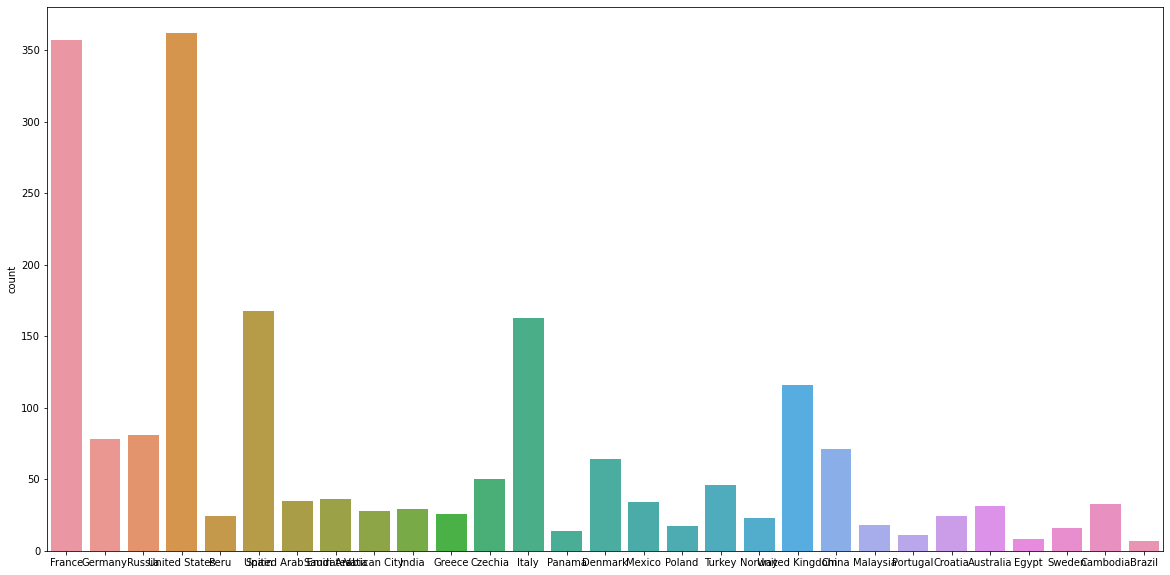

In [11]:
plt.figure(figsize=(20, 10))
sns.countplot(y_data_countries)
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_data_encoded = le.fit_transform(y_data_countries)

print(y_data_countries[:10])
print(y_data_encoded[:10])
print(le.classes_)
print(len(le.classes_))

['France', 'Germany', 'Russia', 'United States', 'Peru', 'United States', 'Spain', 'France', 'United States', 'Russia']
[ 8  9 20 27 17 27 22  8 27 20]
['Australia' 'Brazil' 'Cambodia' 'China' 'Croatia' 'Czechia' 'Denmark'
 'Egypt' 'France' 'Germany' 'Greece' 'India' 'Italy' 'Malaysia' 'Mexico'
 'Norway' 'Panama' 'Peru' 'Poland' 'Portugal' 'Russia' 'Saudi Arabia'
 'Spain' 'Sweden' 'Turkey' 'United Arab Emirates' 'United Kingdom'
 'United States' 'Vatican City']
29


In [13]:
from tensorflow.keras.utils import to_categorical

y_data_encoded = to_categorical(y_data_encoded, num_classes=len(le.classes_))

y_data_encoded[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data_encoded, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1773, 299, 299, 3) (1773, 29)
(197, 299, 299, 3) (197, 29)


In [15]:
from tensorflow.keras.applications import Xception, EfficientNetB3, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [16]:
model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=8,
    epochs=100
)

Epoch 1/100
222/222 [==============================] - 33s 151ms/step - loss: 2.6794 - acc: 0.2572 - val_loss: 3.9327 - val_acc: 0.2335
Epoch 2/100
222/222 [==============================] - 33s 149ms/step - loss: 1.9458 - acc: 0.4473 - val_loss: 2.2749 - val_acc: 0.5178
Epoch 3/100
222/222 [==============================] - 33s 150ms/step - loss: 1.2576 - acc: 0.6283 - val_loss: 2.2250 - val_acc: 0.4619
Epoch 4/100
222/222 [==============================] - 33s 151ms/step - loss: 0.7841 - acc: 0.7620 - val_loss: 3.0740 - val_acc: 0.5279
Epoch 5/100
222/222 [==============================] - 34s 151ms/step - loss: 0.5460 - acc: 0.8421 - val_loss: 0.8647 - val_acc: 0.8020
Epoch 6/100
222/222 [==============================] - 33s 151ms/step - loss: 0.3624 - acc: 0.8945 - val_loss: 0.7156 - val_acc: 0.7919
Epoch 7/100
222/222 [==============================] - 34s 151ms/step - loss: 0.2878 - acc: 0.9143 - val_loss: 4.6505 - val_acc: 0.4772
Epoch 8/100
222/222 [===========================

KeyboardInterrupt: 

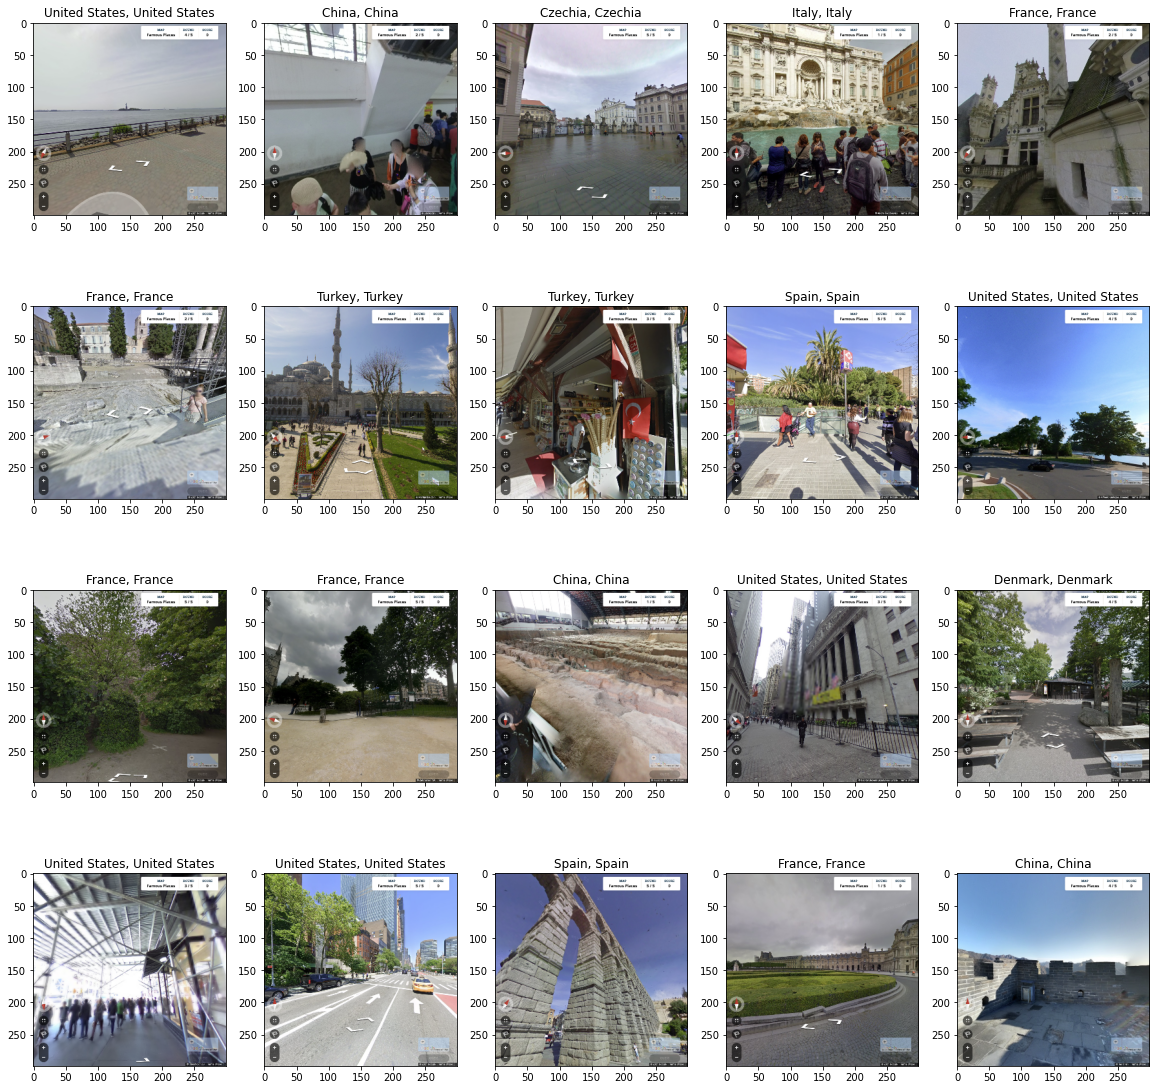

In [18]:
y_pred = model.predict(x_val[:20])
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.inverse_transform(y_pred)
y_true = le.inverse_transform(np.argmax(y_val, axis=1))

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for x, y, y_hat, ax in zip(x_val, y_true, y_pred, axes.flatten()):
    ax.imshow((x[:, :, ::-1] + 1) / 2)
    ax.set_title(f'{y}, {y_hat}')